In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l
import torch.nn.functional as F

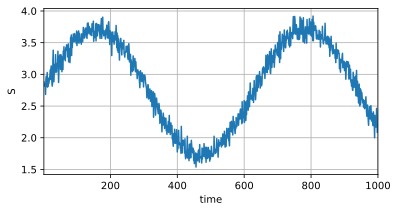

In [2]:
T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
beta=torch.tensor(1.0)
gamma=torch.exp(torch.tensor(1))
I=torch.sin(0.01*time)
S = gamma+beta*I+torch.normal(0, 0.1, (T,))
d2l.plot(time, [S], 'time', 'S', xlim=[1, 1000], figsize=(6, 3))
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = S[i: T - tau + i]
labels = S[tau:].reshape((-1, 1))

In [3]:
batch_size, n_train = 10, 700
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),batch_size, is_train=True)

In [54]:
class paramater_layer(nn.Module):
    def __init__(self,in_size):
        super(paramater_layer,self).__init__()
        self.layer=nn.Sequential(
            nn.Linear(in_size,20),
            nn.ReLU(),
            nn.Linear(20,10),
            nn.ReLU(),
            nn.Linear(10,1)
        )
    def forward(self,x):
        return self.layer(x)

In [55]:
class MyLinear(nn.Module):
    def __init__(self, in_units,device):
        super(MyLinear,self).__init__()
        self.beta = paramater_layer(in_units)
        self.gamma=paramater_layer(in_units)
        self.I=nn.Sequential(
            nn.Linear(in_units,10),
            nn.ReLU(),
            nn.Linear(10,1)
        ).to(device)
        # self.w = nn.Parameter(torch.randn(1),requires_grad=True)
        # self.S=nn.Sequential(
        #     nn.Linear(in_units,1)
        # )
    def forward(self, x):
        linear =self.beta(x)*self.I(x) +self.gamma(x)   # print(linear)
        return linear

In [56]:
device=d2l.try_gpu()
net=MyLinear(tau,device)
def init_weights(m):
        if type(m)==nn.Linear:
            nn.init.xavier_normal_(m.weight)
net.apply(init_weights)

net.to(device=device)

MyLinear(
  (beta): paramater_layer(
    (layer): Sequential(
      (0): Linear(in_features=4, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=10, bias=True)
      (3): ReLU()
      (4): Linear(in_features=10, out_features=1, bias=True)
    )
  )
  (gamma): paramater_layer(
    (layer): Sequential(
      (0): Linear(in_features=4, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=10, bias=True)
      (3): ReLU()
      (4): Linear(in_features=10, out_features=1, bias=True)
    )
  )
  (I): Sequential(
    (0): Linear(in_features=4, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [58]:
loss = nn.MSELoss()
trainer = torch.optim.SGD(net.parameters(), lr=0.005)
num_epochs = 15
for epoch in range(num_epochs):
    for X, y in train_iter:
        X=X.to(device)
        y=y.to(device)
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [43]:
net.beta(features).mean()

AttributeError: 'paramater_layer' object has no attribute 'beta'

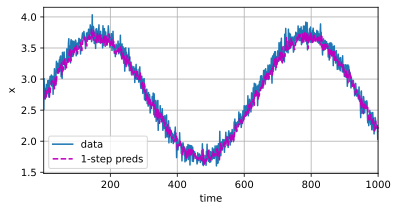

In [51]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [S.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

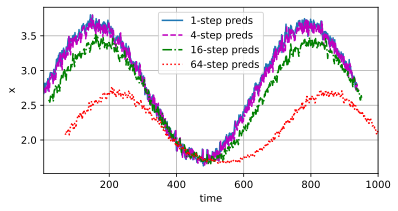

In [52]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = S[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, tau + i - 1].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))